# Synthetic Data Generation: Libraries Comparison

In this notebook we will compare two of the most prominent (open source) Python Packages for data generation: SDV and synthcity. The study will compare the creation of syntetic data from single table, and therefore creating single table as output.
Moreover, I'll create a small Generative Adversarial Network to create synthetic data and compare this simple model with the state-of-art models.

First of all, let's import all the needed libraries.

In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import Metadata
from synthcity.plugins import Plugins

Let's start by importing the data we'll use (Fraud detection dataset from Kaggle Competition)

In [32]:
# Importing the training dataset that we will use to create syntethic data
training_df = pd.read_csv("Datasets/ieee-fraud-detection/train_transaction.csv", nrows=10000) # Taking only the first 10.000 rows for memory limitation

# Inspect data 
print(training_df.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN  

Inspecting the data (Handling missing values)

In [33]:
# Missing values
miss_info = training_df.isnull().sum()

treshold = 0.5 * len(training_df)
missing_column_count = 0
for col, missing_count in miss_info.items():
    if missing_count > treshold:
        missing_column_count += 1
        
print(f"There are {missing_column_count} columns with more than {int(treshold)} missing values")

# Drop these features
training_df = training_df.dropna(axis=1, thresh=treshold)
print(training_df.head())

There are 208 columns with more than 5000 missing values
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...   V312  V313  V314 V315  V316    V317  \
0    NaN  150.0    discover  142.0  ...    0.0   0.0   0.0  0.0   0.0   117.0   
1  404.0  150.0  mastercard  102.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
2  490.0  150.0        visa  166.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
3  567.0  150.0  mastercard  117.0  ...  135.0   0.0   0.0  0.0  50.0  1404.0   
4  514.0  150.0  mastercard  102.0  ...    0.0   0.0   0.0  0.0   0.0     0

How many missing values are still there?

In [ ]:
# Missing values after feature removal
print(training_df.isnull().sum().sum())

# Since many rows have still missing values, impute data with median (numerical) and mode (categorical)
# If rows have too many missing values, drop them
row_threshold = 0.7 * len(training_df.columns)  
training_df.dropna(thresh=row_threshold, inplace=True)

# Impute remaining missing values systematically
training_df = training_df.apply(lambda col: col.fillna(col.mode()[0]) if col.dtype == "object" else col.fillna(col.median()))

print(training_df.isnull().sum().sum())

183863
0


Let's visualize the distribution of transaction amount present in the dataset

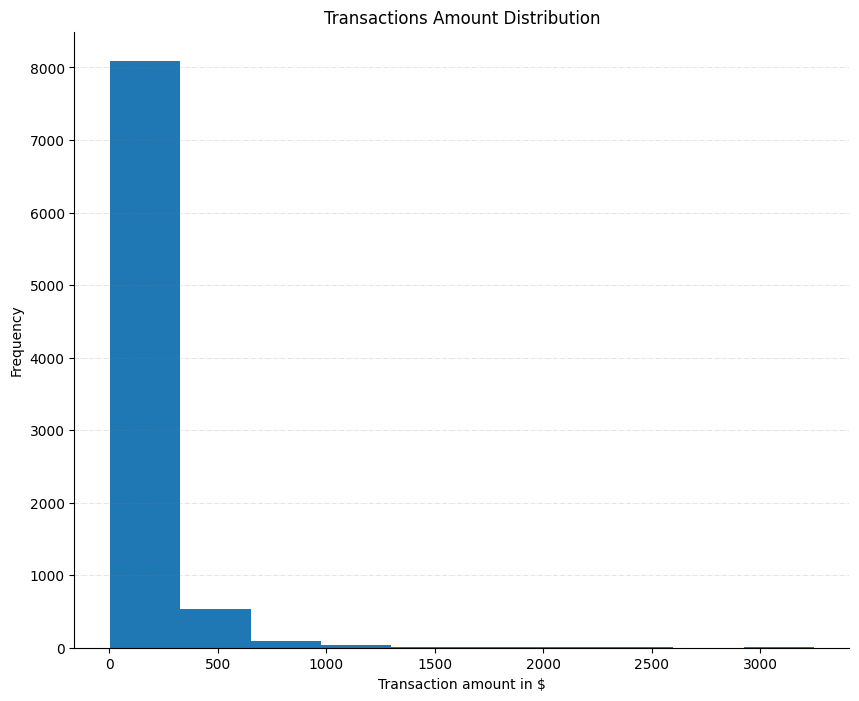

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist(training_df["TransactionAmt"])
ax.set_xlabel("Transaction amount in $")
ax.set_ylabel("Frequency")
ax.set_title("Transactions Amount Distribution")
ax.grid(visible=True, color="grey", linestyle="-.", linewidth=0.5, alpha=0.3, axis="y")
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 
plt.show()

The transaction amount is really right-skwed, since many daily transactions don't require a large amount of money

Now let's start by analyzing the first package: SDV. To use this package correctly we should first create the metadata for the current dataset. This metadata will then be used in the creation of the synthetic data.

In [36]:
# Create Metadata
metadata = Metadata.detect_from_dataframe(
    data=training_df,
    table_name="Fraud_detection")

print(metadata)

{
    "tables": {
        "Fraud_detection": {
            "columns": {
                "TransactionID": {
                    "sdtype": "id"
                },
                "isFraud": {
                    "sdtype": "categorical"
                },
                "TransactionDT": {
                    "sdtype": "numerical"
                },
                "TransactionAmt": {
                    "sdtype": "numerical"
                },
                "ProductCD": {
                    "sdtype": "categorical"
                },
                "card1": {
                    "sdtype": "numerical"
                },
                "card2": {
                    "sdtype": "numerical"
                },
                "card3": {
                    "sdtype": "numerical"
                },
                "card4": {
                    "sdtype": "categorical"
                },
                "card5": {
                    "sdtype": "numerical"
                },
                "c

After creating the metadata we can create the syntethizer. This is the description of a synthetizer that can be found in the SDV documentation page: 

"The SDV creates synthetic data using machine learning. A synthesizer is an object that you can use to accomplish this task.

1. You'll start by creating a synthesizer based on your metadata

2. Next, you'll train the synthesizer using real data. In this phase, the synthesizer will learn patterns from the real data.

2. Once your synthesizer is trained, you can use it to generate new, synthetic data."

There are different type of synthesizer, Each synthesizer uses a different machine learning technique for training. In this study we will try:
- GaussianCopulaSynthesizer: The Gaussian Copula Synthesizer uses classic, statistical methods to train a model and generate synthetic data.
- CTGANSynthesizer: The CTGAN Synthesizer uses GAN-based, deep learning methods to train a model and generate synthetic data.
- TVAESynthesizer: The TVAE Synthesizer uses a variational autoencoder (VAE)-based, neural network techniques to train a model and generate synthetic data.

Let's start with GaussianCopulaSynthesizer.

In [37]:
# Create the synthesizer
synthesizer_gaussian_SDV = GaussianCopulaSynthesizer(metadata)

# Training
#synthesizer_gaussian_SDV.fit(training_df)

# Syntetic data generation
#synthetic_data_gaussian_SDV = synthesizer_gaussian_SDV.sample(num_rows=10000)
#print(synthetic_data_gaussian_SDV)

# Save the data
#synthetic_data_gaussian_SDV.to_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv", index=False)

Next let's try the CTGANSynthesizer (This step will be performed in a separate Google Colab Notebook to take advantage of the Free GPU offered, the code can still be seen below. The synthetic data created by the CTGANSynthesizer will be directly imported later in the notebook)

In [38]:
"""# Create the synthesizer
synthesizer_CTGAN = CTGANSynthesizer(metadata)
# Training
synthesizer_CTGAN.fit(training_df)

# Syntetic data generation
synthetic_data_CTGAN = synthesizer_CTGAN.sample(num_rows=10000)
print(synthetic_data_CTGAN)

# Save the data
synthetic_data_CTGAN.to_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv", index=False)"""

'# Create the synthesizer\nsynthesizer_CTGAN = CTGANSynthesizer(metadata)\n# Training\nsynthesizer_CTGAN.fit(training_df)\n\n# Syntetic data generation\nsynthetic_data_CTGAN = synthesizer_CTGAN.sample(num_rows=10000)\nprint(synthetic_data_CTGAN)\n\n# Save the data\nsynthetic_data_CTGAN.to_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv", index=False)'

Same process for the TVAESynthesizer.

In [39]:
"""# Create the synthesizer
synthesizer_TVAE_SDV = TVAESynthesizer(metadata)
# Training
synthesizer_TVAE_SDV.fit(training_df)


# Syntetic data generation
synthetic_data_TVAE_SDV = synthesizer_TVAE_SDV.sample(num_rows=10000)

# Save the data
synthetic_data_TVAE_SDV.to_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv", index=False)"""

'# Create the synthesizer\nsynthesizer_TVAE_SDV = TVAESynthesizer(metadata)\n# Training\nsynthesizer_TVAE_SDV.fit(training_df)\n\n\n# Syntetic data generation\nsynthetic_data_TVAE_SDV = synthesizer_TVAE_SDV.sample(num_rows=10000)\n\n# Save the data\nsynthetic_data_TVAE_SDV.to_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv", index=False)'

Before to compare the statistical similarity of the synthetic data to the real data "by hand", I will use some of the disgnostics and data validation functions that the SDV Package offers. For example let's start with the run_diagnostic function that should perfrom a basic validity check for each column and ensure that the structure of the dataset is preserved. Therefore, the score after running this function should be 100%, as stated in the documentation of the package.

In [40]:
# Import the data created by the Three models (To not retrain the model everytime, and make the notebook run smothly)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv")
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")

print("Diagnostic Report for GaussianCopulaSynthesizer")
diagnostic_report_gaussian_SDV = run_diagnostic(
    real_data=training_df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Diagnostic Report for CTGANSynthesizer")
diagnostic_report_CTGAN_SDV = run_diagnostic(
    real_data=training_df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Diagnostic Report for TVAESynthesizer")
diagnostic_report_TVAE_SDV = run_diagnostic(
    real_data=training_df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

Diagnostic Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 186/186 [00:00<00:00, 2011.52it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 324.86it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 186/186 [00:00<00:00, 2014.82it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 300.62it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 186/186 [00:00<00:00, 2057.95it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 468.43it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



SDV also offer a function to create a data quality report that checks for statistical similarity between the real and the synthetic data. I will use this function to try and calculate the statistical similarity by hand.

In [41]:
# Create the quality report for the three models
# Commented out to smoothing the notebook running
"""print("Quality Report for GaussianCopulaSynthesizer")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=training_df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=training_df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=training_df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)"""

"""# Save these results
quality_report_gaussian_SDV.save(filepath="Results_SDV/quality_report_gaussian.pkl")
quality_report_CTGAN_SDV.save(filepath="Results_SDV/quality_report_CTGAN.pkl")
quality_report_TVAE_SDV.save(filepath="Results_SDV/quality_report_TVAE.pkl")"""

'# Save these results\nquality_report_gaussian_SDV.save(filepath="Results_SDV/quality_report_gaussian.pkl")\nquality_report_CTGAN_SDV.save(filepath="Results_SDV/quality_report_CTGAN.pkl")\nquality_report_TVAE_SDV.save(filepath="Results_SDV/quality_report_TVAE.pkl")'

Another feature offered by SDV is to visualize in 2D the data. This can help see what kind of patterns the synthetic data has learned, and identify differences between the real and synthetic data.

In [42]:
# Plot for the GaussianCopulaSynthesizer
fig_gaussian_SDV = get_column_plot(
    real_data=training_df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata,
    column_name="TransactionAmt"
)
    
fig_gaussian_SDV.show()

In [43]:
# Plot for the CTGAN model
fig_CTGAN_SDV = get_column_plot(
    real_data=training_df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata,
    column_name="TransactionAmt"
)
    
fig_CTGAN_SDV.show()

In [44]:
# Plot for the TVAESynthesizer model
fig_TVAE_SDV = get_column_plot(
    real_data=training_df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata,
    column_name="TransactionAmt"
)
    
fig_TVAE_SDV.show()

## Synthcity Generator

In [45]:
# Check available models
print(Plugins().list())

# Create Gaussian Mixture Model (Comparison with SDV GaussianCopula)
synthesizer_bayes_net_SYN = Plugins().get("bayesian_network")
print("Model initialized Successfully")

# Train on real data (TRAIN ON GPU)
synthesizer_bayes_net_SYN.fit(training_df)

# Generate synthetic data
synthetic_data_bayes_net_SYN = synthesizer_bayes_net_SYN.generate(10000)
print(synthetic_data_bayes_net_SYN.head())

# Save the data
synthetic_data_bayes_net_SYN.to_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN.csv", index=False)

# Model to compare
# GaussianCopula VS bayesian_network (Both probabilistic models)
# CTGAN VS ctgan (Exact match)
# TVAE VS tvae (Exact Match)

[2025-02-16T22:48:58.193611+0100][13428][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-02-16T22:48:58.196610+0100][13428][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py


['uniform_sampler', 'survival_ctgan', 'survival_nflow', 'privbayes', 'ddpm', 'decaf', 'nflow', 'tvae', 'great', 'survival_gan', 'image_adsgan', 'aim', 'timevae', 'marginal_distributions', 'rtvae', 'survae', 'arf', 'adsgan', 'radialgan', 'timegan', 'dpgan', 'image_cgan', 'pategan', 'fflows', 'dummy_sampler', 'ctgan', 'bayesian_network']
Model initialized Successfully


MemoryError: Unable to allocate 573. MiB for an array with shape (8532, 8808) and data type float64

In [ ]:
synthesizer_ctgan_SYN = Plugins().get("ctgan")

synthesizer_ctgan_SYN.fit(training_df)

synthetic_data_ctgan_SYN = synthesizer_ctgan_SYN.generate(10000)
print(synthetic_data_ctgan_SYN.head())

In [ ]:
synthesizer_timegan_SYN = Plugins().get("timegan")

synthesizer_timegan_SYN.fit(training_df)

synthetic_data_timegan_SYN = synthesizer_timegan_SYN.generate(10000)
print(synthetic_data_timegan_SYN.head())

## COMPARE DATASETS STATISTICS

For the moment I used the built in functions provided by the package (SDV) itself. 